# **1. Импорт библиотек**

In [2]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!pip freeze > requirements.txt

# **2. Выгружаем данные**

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
train.shape

(73799, 19)

In [9]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

In [10]:
# Размерность тестового датасета:
test.shape

(36349, 18)

In [11]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

None

### В датасете test нет перемнной "default". Мы должны предсказать значение указанной переменной, предварительно заполним ее нулями. Для корректной обработки признаков объединим датасеты train и test, предварительно в новой переменной "train" указав, какие записи относятся к датасету train.

In [13]:
test['default'] = 0 # заполняем переменную нудями
test['train'] = 0 # указываем, что записи не принадлежат датасету train
train['train'] = 1 # указываем, что записи принадлежат датасету train
data = train.append(test, sort = False).reset_index(drop=True) # объединяем датасеты в один

# **3. Предварительный анализ данных**

In [14]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,0,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,0,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,0,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,0,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### Видим наличие пропусков в переменной "education". Поработаем с ней.

In [17]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
dtype: int64

<AxesSubplot:>

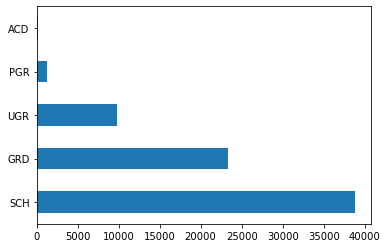

In [18]:
# определяем наиболее часто встречающимся значением в переменной 'education'
train['education'].value_counts().plot.barh()

In [19]:
# заполням пропущенные значения в переменной 'education' значением "SCH"
data[data['education'].isnull()] = data[data['education'].isnull()].fillna('SCH')

In [15]:
# посмотрим количество уникальных значений в каждой переменной датасета
data.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
train                    2
dtype: int64

### Выделим из датасета бинарные (за исключением 'default' и 'train'), категориальные и числовые признаки (за исключением 'client_id').

In [29]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

# **4. Анализ и преобразование данных**

**4.1 Целевая переменная 'default'**

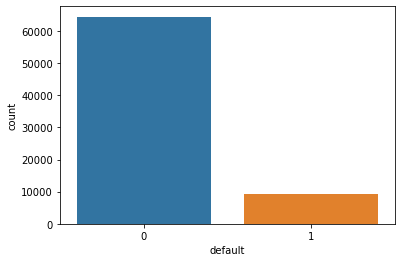

In [17]:
sns.countplot(x='default', data=data[data['train'] == 1])

**4.2 Переменная 'app_date'**

In [18]:
# пребразуем значения переменной в формат datetime
data.app_date = pd.to_datetime(data.app_date)
data.app_date

0        2014-02-01
1        2014-03-12
2        2014-02-01
3        2014-01-23
4        2014-04-18
            ...    
110143   2014-03-31
110144   2014-04-25
110145   2014-03-30
110146   2014-01-07
110147   2014-03-17
Name: app_date, Length: 110148, dtype: datetime64[ns]

### Первый ризнак, который нас интересует - кол-во заявок поданных за каждый день рассматриваемого периода.

In [22]:
num_of_app_train = data['app_date'][data['train']==1].value_counts()
num_of_app_train

18MAR2014    1018
17MAR2014     911
19MAR2014     909
31MAR2014     904
07APR2014     882
             ... 
20APR2014     243
07JAN2014     228
03JAN2014     193
02JAN2014     137
01JAN2014      43
Name: app_date, Length: 120, dtype: int64

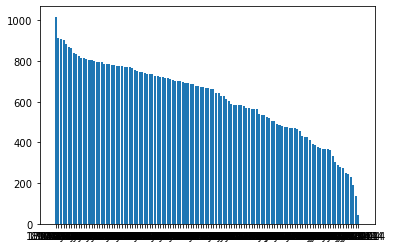

In [23]:
plt.bar(num_of_app_train.index, num_of_app_train)
plt.show()

### Кол-во заявок в начеле года больше. Ближе к концу рассматриваемого периода наметился тренд на снижение.

### Сделующий признак - распределение дефолтов по дате подачи заявки.

In [24]:
num_of_def_train = data['app_date'][(data['train']==1) & (data['default'] == 1)].value_counts()
num_of_def_train

28JAN2014    129
17MAR2014    129
23JAN2014    122
18MAR2014    121
02APR2014    119
            ... 
20APR2014     25
03JAN2014     24
13APR2014     20
02JAN2014     18
01JAN2014      6
Name: app_date, Length: 120, dtype: int64

### Посмотрим на распределение кол-ва дефолтов по дате выдачи заявки.

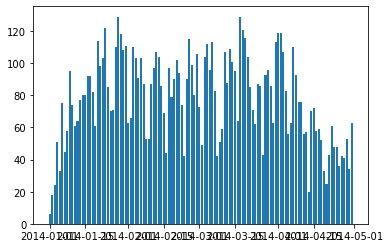

In [22]:
plt.bar(num_of_def_train.index, num_of_def_train)
plt.show()

### По графику видно, что в начале кол-во дефолтов росло. Ближе к концу рассматриваемого периода наметился тренд на снижение. Можно сделать вывод, что банк стал лучше работать со временем: он стал меньше выдавать потенциально проблемных кредитов и кол-во дефолтов снизилось.

### Создадим новые признаки на основе переменной 'app_date'.

In [25]:
# добавим в датасет data кол-во заявок, поданных в каждую дату по данным датасета train
data['num_of_app'] = data['app_date'].replace(to_replace=num_of_app_train.to_dict())

# добавим в датасет data кол-во дефолтов, на каждую дату поданной заявки по данным датасета train
data['num_of_def'] = data['app_date'].replace(to_replace=num_of_def_train.to_dict())
data

# на основе добаленных переменных создадим новую - доля дефолтов от кол-ва поданных заявок
data['share_of_def'] = data['num_of_def']/data['num_of_app']
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,train,num_of_app,num_of_def,share_of_def
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,2,18000,4,1,N,0,1,542,63,0.116236
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,3,19000,4,1,N,0,1,737,88,0.119403
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,2,30000,1,4,Y,0,1,542,63,0.116236
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,3,10000,1,3,N,0,1,703,122,0.173542
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,3,30000,1,4,Y,0,1,661,52,0.078669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,...,3,15000,4,1,N,0,0,904,113,0.125000
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,...,2,200000,1,4,N,0,0,470,36,0.076596
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,...,2,60000,4,2,N,0,0,475,63,0.132632
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,...,3,30000,1,1,N,0,0,228,45,0.197368


### Уберем из датасета data кол-во дефолтов по данным датасета train,  т.к. в новом датасете data картина может быть другой.

In [26]:
del data['num_of_def']

### Также заменим значения в переменной кол-во заявок по данным датасета train на кол-во заявок в новом датасете data. (Т.е. по сути, добавим эту информацию для записей из датасета test.)

In [27]:
num_of_app_data = data['app_date'].value_counts()
data['num_of_app'] = data['app_date'].replace(to_replace=num_of_app_data.to_dict())

In [30]:
# добавим новые переменные 'share_of_def', 'num_of_app' в список числовых переменных
num_cols.append('share_of_def')
num_cols.append('num_of_app')

In [27]:
# проверяем, что переменные добавлены
print(num_cols)
display(data)

['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'share_of_def', 'num_of_app']


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,train,num_of_app,share_of_def
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,1,2,18000,4,1,N,0,1,794,0.116236
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,2,3,19000,4,1,N,0,1,1110,0.119403
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,1,2,30000,1,4,Y,0,1,794,0.116236
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,...,2,3,10000,1,3,N,0,1,1060,0.173542
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,...,2,3,30000,1,4,Y,0,1,981,0.078669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,2014-03-31,SCH,F,37,N,N,1,0,-1.744976,...,2,3,15000,4,1,N,0,0,1317,0.125000
110144,106254,2014-04-25,GRD,F,64,Y,Y,0,0,-2.293781,...,1,2,200000,1,4,N,0,0,698,0.076596
110145,81852,2014-03-30,GRD,M,31,N,N,2,0,-0.940752,...,1,2,60000,4,2,N,0,0,722,0.132632
110146,1971,2014-01-07,UGR,F,27,N,N,1,0,-1.242392,...,2,3,30000,1,1,N,0,0,349,0.197368


**4.3 Категориальные переменные**

Бинарная переменная "education":
SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64


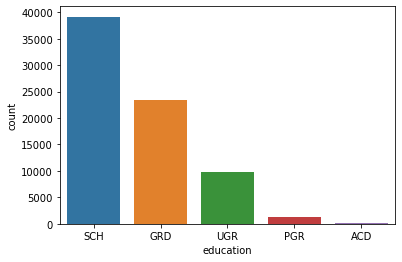

Бинарная переменная "home_address":
2    39956
1    32585
3     1258
Name: home_address, dtype: int64


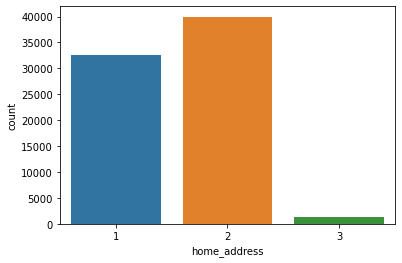

Бинарная переменная "work_address":
3    44959
2    20506
1     8334
Name: work_address, dtype: int64


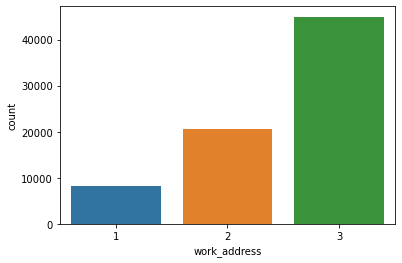

Бинарная переменная "sna":
1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64


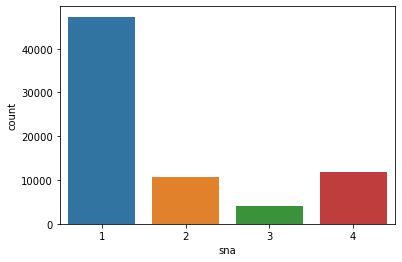

Бинарная переменная "first_time":
3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64


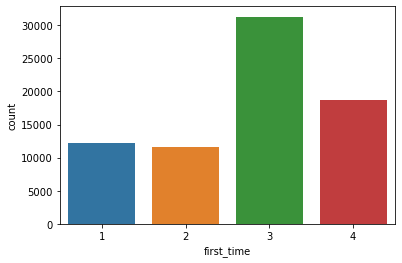

In [31]:
# работаем по циклу с переменными 
# рассматриваем для строк из датасета train
for col in cat_cols:
    print('Бинарная переменная "{a}":'.format(a=col)) # выводим название переменной
    print(data[col][data['train']==1].value_counts()) # выводим уникальные значения и их количество
    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data=data[data['train']==1])
    plt.show()

### Выводы:
#### в переменной "education" приходится малая доля на значения PGR и ACD,
#### в переменной "home_address" приходится малая доля на значение 3.
#### Для остальных переменных доля всех значений достаточно велика, но имется один ярко выраженный признак.

**4.4 Бинарные переменные**

Бинарная переменная "sex":
F    41562
M    32237
Name: sex, dtype: int64


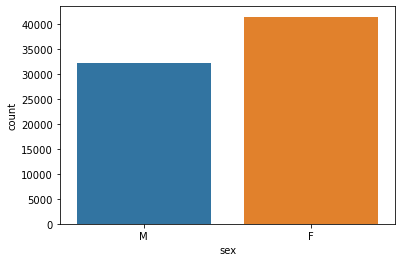

Бинарная переменная "car":
N    49832
Y    23967
Name: car, dtype: int64


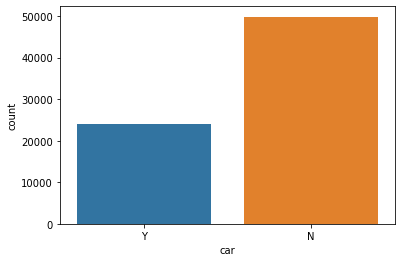

Бинарная переменная "car_type":
N    59791
Y    14008
Name: car_type, dtype: int64


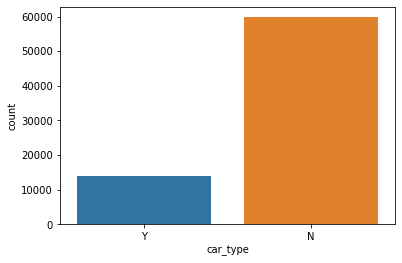

Бинарная переменная "good_work":
0    61630
1    12169
Name: good_work, dtype: int64


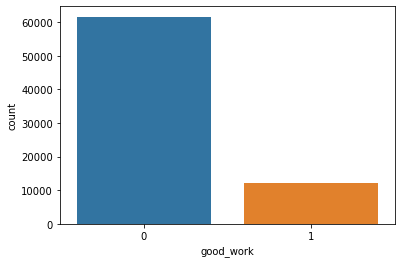

Бинарная переменная "foreign_passport":
N    62733
Y    11066
Name: foreign_passport, dtype: int64


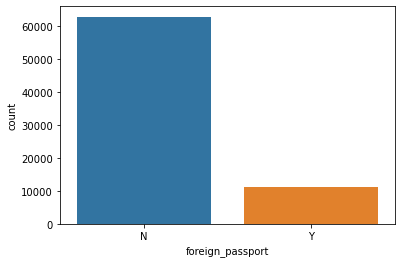

In [32]:
# работаем по циклу с переменными 
# рассматриваем для строк из датасета train
for col in bin_cols:
    print('Бинарная переменная "{a}":'.format(a=col)) # выводим название переменной
    print(data[col][data['train']==1].value_counts()) # выводим уникальные значения и их количество
    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data=data[data['train']==1])
    plt.show()

### Выводы:
#### в переменной "sex" значения распределены примерно поровну,
#### в остальных переменные распределение неравномерно - имеется серьезное преобладание одного из признаков.

**4.4 Числовые переменные**

In [ ]:
# работаем по циклу с переменными 
# рассматриваем для строк из датасета train
for col in num_cols:
    print('Числовая переменная "{a}":'.format(a=col)) # выводим название переменной
    print(data[col][data['train']==1].describe())
    # выводим распределение заемщиков по признакам
    data[col].hist(bins=20)
    plt.show()

Числовая переменная "age":
count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64


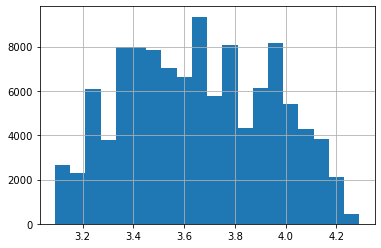

Числовая переменная "decline_app_cnt":
count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64


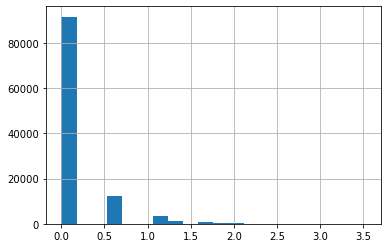

Числовая переменная "score_bki":
count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64


/Users/vaceslav/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


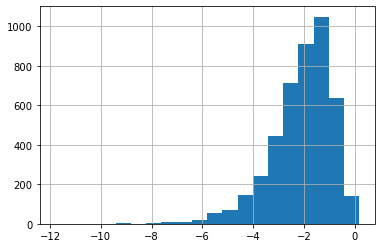

Числовая переменная "bki_request_cnt":
count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64


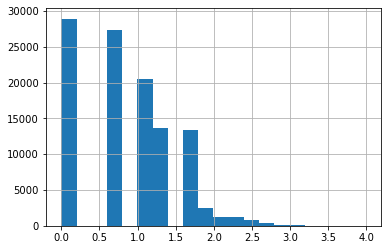

Числовая переменная "region_rating":
count    73799.000000
mean        56.725701
std         13.055717
min         20.000000
25%         50.000000
50%         50.000000
75%         60.000000
max         80.000000
Name: region_rating, dtype: float64


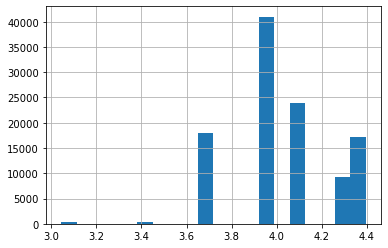

Числовая переменная "income":
count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


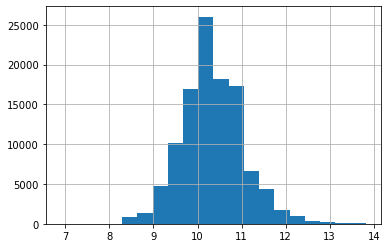

Числовая переменная "share_of_def":
count    73799.000000
mean         0.126994
std          0.020828
min          0.076596
25%          0.115489
50%          0.129464
75%          0.140306
max          0.203252
Name: share_of_def, dtype: float64


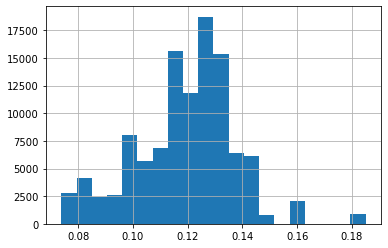

Числовая переменная "num_of_app":
count    73799.000000
mean      1003.073212
std        235.056937
min         56.000000
25%        848.000000
50%       1071.000000
75%       1173.000000
max       1491.000000
Name: num_of_app, dtype: float64


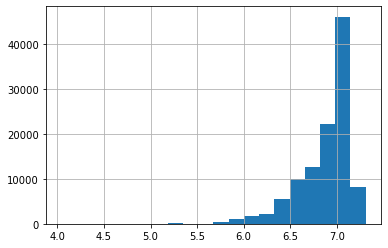

In [33]:
# посмотрим на распределение логарифмов переменных
# рассматриваем для строк из датасета train
for col in num_cols:
    print('Числовая переменная "{a}":'.format(a=col)) # выводим название переменной
    print(data[col][data['train']==1].describe())
    # выводим распределение заемщиков по признакам
    np.log(data[col]+1).hist(bins=20)
    plt.show()

Числовая переменная "age":
count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64


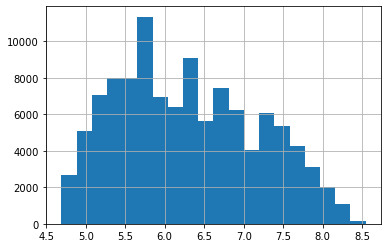

Числовая переменная "decline_app_cnt":
count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64


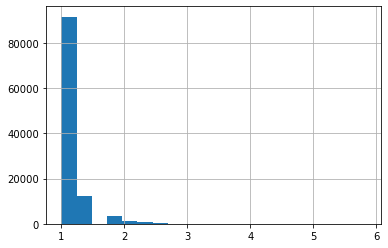

Числовая переменная "score_bki":
count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64


/Users/vaceslav/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


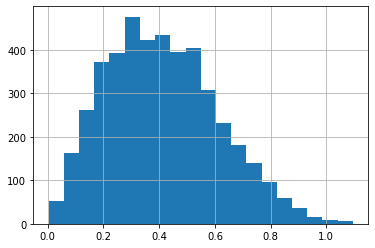

Числовая переменная "bki_request_cnt":
count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64


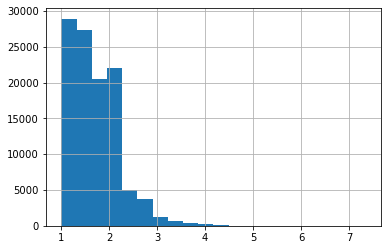

Числовая переменная "region_rating":
count    73799.000000
mean        56.725701
std         13.055717
min         20.000000
25%         50.000000
50%         50.000000
75%         60.000000
max         80.000000
Name: region_rating, dtype: float64


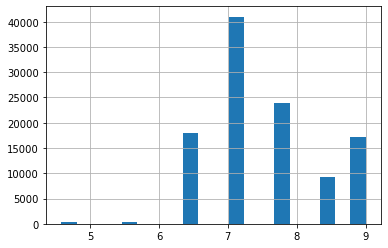

Числовая переменная "income":
count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


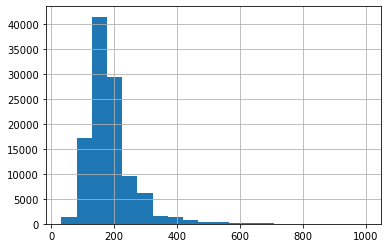

Числовая переменная "share_of_def":
count    73799.000000
mean         0.126994
std          0.020828
min          0.076596
25%          0.115489
50%          0.129464
75%          0.140306
max          0.203252
Name: share_of_def, dtype: float64


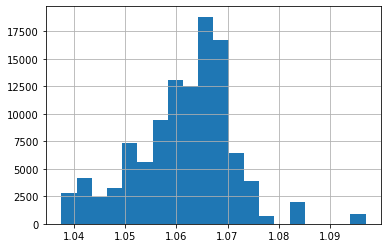

Числовая переменная "num_of_app":
count    73799.000000
mean      1003.073212
std        235.056937
min         56.000000
25%        848.000000
50%       1071.000000
75%       1173.000000
max       1491.000000
Name: num_of_app, dtype: float64


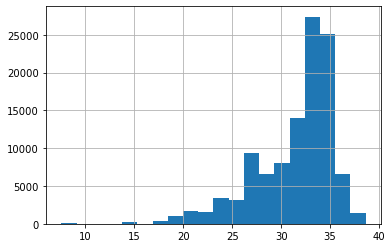

In [34]:
# посмотрим на распределение квадратных корней из переменных
# рассматриваем для строк из датасета train
for col in num_cols:
    print('Числовая переменная "{a}":'.format(a=col)) # выводим название переменной
    print(data[col][data['train']==1].describe())
    # выводим распределение заемщиков по признакам
    np.sqrt(data[col]+1).hist(bins=20)
    plt.show()

#### Видим, что для переменных "age", "bki_request_cnt", "income" распределение логарифов более нормальное. Поэтому заменим значения тих переменных в датасете data на логарифмы. Переменные "decline_app_cnt" "score_bki"б "region_rating" оставим без изменений - логарифмирование и извлечение квадратного корня не делают распределение более нормальным.

In [35]:
# замену производим для всего датасета data
data['age'] = np.log(data['age']+1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt']+1)
data['income'] = np.log(data['income']+1)

Числовая переменная "age":
count    110148.000000
mean          3.654546
std           0.285054
min           3.091042
25%           3.433987
50%           3.637586
75%           3.891820
max           4.290459
Name: age, dtype: float64


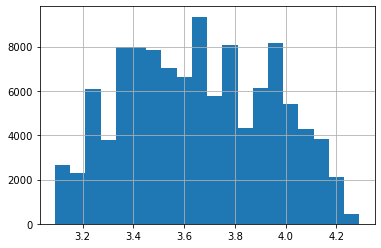

Числовая переменная "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


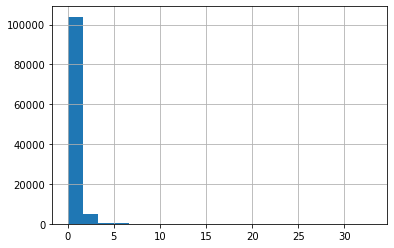

Числовая переменная "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


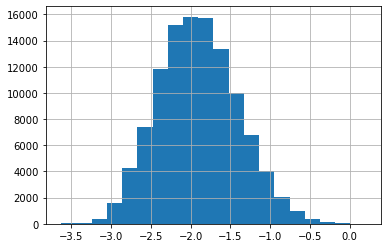

Числовая переменная "bki_request_cnt":
count    110148.000000
mean          0.878752
std           0.658667
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt, dtype: float64


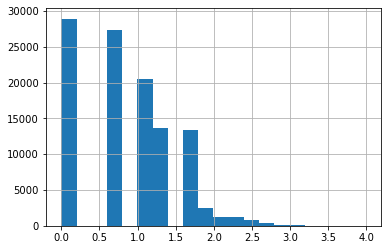

Числовая переменная "region_rating":
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64


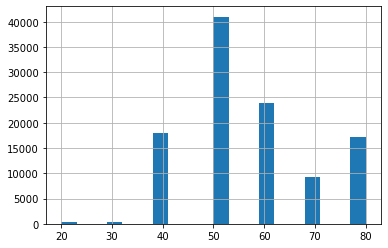

Числовая переменная "income":
count    110148.000000
mean         10.345792
std           0.696636
min           6.908755
25%           9.903538
50%          10.308986
75%          10.778977
max          13.815512
Name: income, dtype: float64


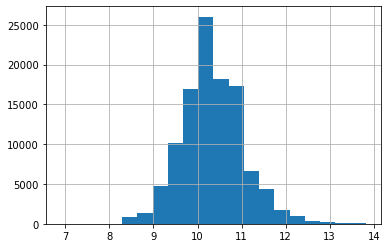

Числовая переменная "share_of_def":
count    110148.000000
mean          0.127022
std           0.020775
min           0.076596
25%           0.115489
50%           0.129464
75%           0.140306
max           0.203252
Name: share_of_def, dtype: float64


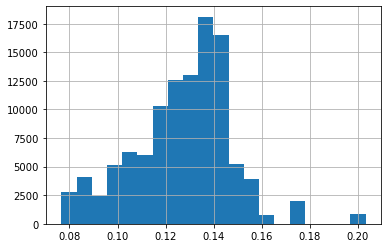

Числовая переменная "num_of_app":
count    110148.000000
mean       1002.761267
std         234.959584
min          56.000000
25%         848.000000
50%        1071.000000
75%        1173.000000
max        1491.000000
Name: num_of_app, dtype: float64


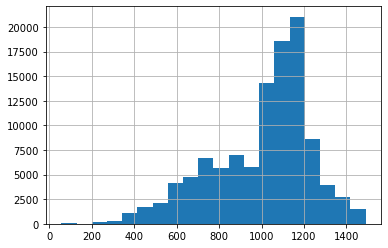

In [36]:
# посмотрим на распределения получишихся переменных
# смотрим для всего датасета data
for col in num_cols:
    print('Числовая переменная "{a}":'.format(a=col)) # выводим название переменной
    print(data[col].describe())
    # выводим распределение заемщиков по признакам
    data[col].hist(bins=20)
    plt.show()

# **5. Оценка значимости переменных**

**5.1 Преобразования бинарных переменных**

In [38]:
# посмотрим детальнее, какие данные хранятся в бинарных переменных
data[bin_cols]

,sex,car,car_type,good_work,foreign_passport
0,M,Y,Y,0,N
1,F,N,N,0,N
2,M,Y,N,0,Y
3,F,N,N,0,N
4,M,N,N,1,Y
...,...,...,...,...,...
110143,F,N,N,0,N
110144,F,Y,Y,0,N
110145,M,N,N,0,N
110146,F,N,N,0,N


In [39]:
# преобразуем даные с помощью метода fit класса LabelEncoder
# работаем со всем датасетом data
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = pd.Series(label_encoder.fit_transform(data[col]))

In [40]:
# проверим преобразования
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


**5.2 Преобразования категориальных переменных**

In [41]:
# посмотрим детальнее, какие данные хранятся в категориальных переменных
data[cat_cols]

,education,home_address,work_address,sna,first_time
0,SCH,1,2,4,1
1,SCH,2,3,4,1
2,SCH,1,2,1,4
3,SCH,2,3,1,3
4,GRD,2,3,1,4
...,...,...,...,...,...
110143,SCH,2,3,4,1
110144,GRD,1,2,1,4
110145,GRD,1,2,4,2
110146,UGR,2,3,1,1


In [42]:
# преобразуем переменную "education"
# работаем со всем датасетом data
label_encoder = LabelEncoder()
data['education'] = pd.Series(label_encoder.fit_transform(data['education']))

In [43]:
# проверим преобразования
data[cat_cols]

,education,home_address,work_address,sna,first_time
0,3,1,2,4,1
1,3,2,3,4,1
2,3,1,2,1,4
3,3,2,3,1,3
4,1,2,3,1,4
...,...,...,...,...,...
110143,3,2,3,4,1
110144,1,1,2,1,4
110145,1,1,2,4,2
110146,4,2,3,1,1


5.3 Оценка корреляций

<AxesSubplot:>

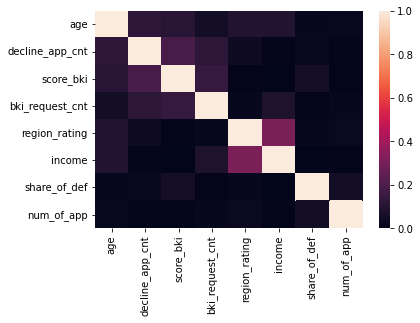

In [44]:
# оценим корреляцию Пирсона для числовых переменных
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

### Выводы:
#### 1.Признаки слабо коррелированы между собой
#### 2.Все признаки будем использовать в модели.

<AxesSubplot:>

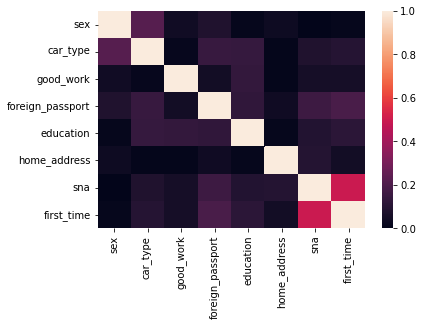

In [64]:
# оценим корреляцию Спирмана для нечисловых переменных
sns.heatmap(data[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1)

### Выводы:
#### 1.Высокая коррекляция перемнных car и car_type. В модели будем использовать перемнную car_type.
#### 2.Высокая корреляция переменных home_address и work_address. В модели будем использовать перемнную home_address.

In [65]:
# оставим бинарные и категориальные переменные, которые будут использоваться в модели
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'sna', 'first_time']

**5.3 Оценка значимости числовых переменных**

<AxesSubplot:>

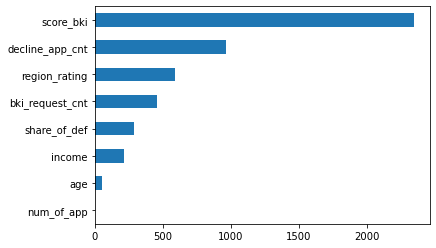

In [66]:
# проверяем значимость переменных
# работаем с записями из датасета train
imp_num = pd.Series(f_classif(data[data['train'] == 1][num_cols],
                              data[data['train'] == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

#### Как и ожидалось, самая важная переменная - 'score_bki'. В тоже время 'num_of_app' наименее важна.

**5.4 Оценка значимости категориальных и бинарных переменных**

<AxesSubplot:>

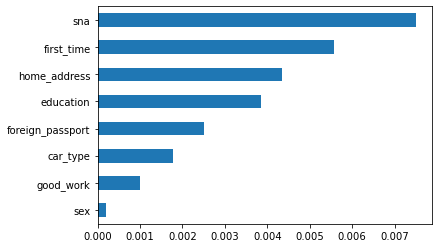

In [67]:
# проверяем значимость переменных
# работаем с записями из датасета train
imp_cat = Series(mutual_info_classif(data[data['train'] == 1][bin_cols + cat_cols], data[data['train'] == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#### Самая важная переменная - 'sna'. Наименее важная переменная - 'sex' не важна. Все переменные будем использовать в модели.

# **6. Строим модель**

In [68]:
# выделяем тренировочный датасет из датасета data
data_train = data[data['train'] == 1]
data_train = data_train.drop(['client_id', 'app_date', 'train'], axis=1)

In [69]:
# проверяем тренировочный датасет
display(data_train.head(5))

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,num_of_app,share_of_def
0,3,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,794,0.116236
1,3,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,1110,0.119403
2,3,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,794,0.116236
3,3,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,1060,0.173542
4,1,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,981,0.078669


In [70]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73799 non-null  int64  
 1   sex               73799 non-null  int64  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int64  
 4   car_type          73799 non-null  int64  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int64  
 16  default           73799 non-null  int64 

In [71]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_train_cat = OneHotEncoder(sparse = False).fit_transform(data_train[cat_cols].values)

In [72]:
# проверяем
data_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [73]:
# стандартизируем числовые переменные
data_train_num = StandardScaler().fit_transform(data_train[num_cols].values)

In [74]:
# проверяем
data_train_num

array([[ 1.71113664, -0.34285766, -0.2087987 , ..., -0.78501579,
        -0.51650253, -0.88946377],
       [ 1.5399884 , -0.34285766,  0.74754461, ..., -0.70752611,
        -0.36445207,  0.45490047],
       [-1.39343857,  2.14387966,  0.99669566, ..., -0.05288771,
        -0.51650253, -0.88946377],
       ...,
       [-0.66507223, -0.34285766,  0.78696739, ...,  0.5282444 ,
        -1.73254563, -0.03860032],
       [-0.89146325, -0.34285766,  0.85380611, ..., -1.25140899,
         2.34635007, -2.36571184],
       [-0.35072683, -0.34285766,  0.28102087, ..., -0.31419734,
         2.2349535 ,  0.24218461]])

In [75]:
# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_train_num, data_train[bin_cols].values, data_train_cat])
y = data_train['default'].values

In [76]:
# Разобьем данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [77]:
# строим модель
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/vaceslav/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# **7. Оценка качества модели**

**7.1 ROC-анализ**

In [78]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [79]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

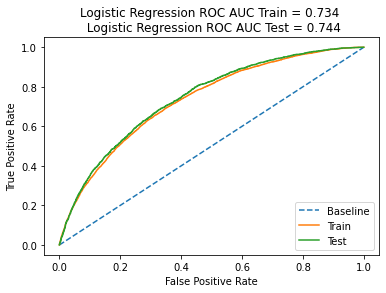

In [80]:
# строим графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### Вывод: метрика ROC AUC для обучающей и тестовоый выборок близка. Посмотрим, можно ли найти более оптимальные параметры для модели.

# **8. Поиск оптимальных значений гиперпараметров**

In [81]:
# импорт библиотеки
from sklearn.model_selection import GridSearchCV

In [83]:
# ищем оптимальные значения гиперпараметров
model = LogisticRegression()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
        print(param_name, best_parameters[param_name], '\n')

KeyboardInterrupt: 

## 9. Строим модель с подобранными гиперпарметрами

In [84]:
# Разобьем данные для обучения и тестирования по новой
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [85]:
# строим модель
new_model = LogisticRegression(random_state = None, 
                               C = 1, 
                               class_weight = 'balanced', 
                               dual = False, 
                               fit_intercept = True, 
                               intercept_scaling = 1, 
                               l1_ratio = None, 
                               max_iter = 100, 
                               multi_class = 'auto', 
                               n_jobs = None, 
                               penalty = 'l1', 
                               solver = 'liblinear', 
                               tol = 0.0001,
                               verbose = 0, 
                               warm_start = False)
new_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [86]:
# считаем метрики обучающещей (X_train, y_train) выборки
y_train_probs = new_model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [87]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = new_model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

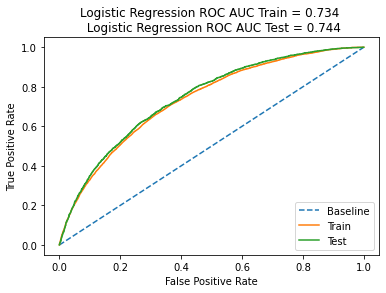

In [88]:
# строи графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### Вывод: расхождение метрика ROC AUC для обучающей и тестовоый выборок не изменилось. Будем использовать модель с подобранными гиперпараметрами.

# **9. Определяем значение дефолта клиентов**

In [89]:
# выделяем тестовый датасет из датасета data
data_test = data[data['train'] == 0]
data_test = data_test.drop(['client_id', 'app_date', 'train'], axis=1)

In [90]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_test_cat = OneHotEncoder(sparse = False).fit_transform(data_test[cat_cols].values)

In [91]:
# проверяем
data_test_cat

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [92]:
# стандартизируем числовые переменные
data_test_num = StandardScaler().fit_transform(data_test[num_cols].values)

In [93]:
# проверяем
data_test_num

array([[-0.88333898, -0.33995109, -0.73288746, ...,  0.68282058,
         0.4450004 , -0.99730532],
       [ 0.12606863,  6.00146439,  0.79551047, ..., -2.63253397,
        -0.56077739,  0.35300684],
       [ 0.97850869, -0.33995109,  0.42413578, ..., -0.05272498,
         0.31650603, -1.33807811],
       ...,
       [-0.65688874,  2.1966151 ,  1.92005304, ...,  0.9453502 ,
         0.26864856, -1.19324967],
       [-1.12541848,  0.92833201,  1.31888606, ..., -0.05272498,
         3.40089756, -2.78210279],
       [ 0.0372345 , -0.33995109,  0.79042787, ..., -1.05077617,
         0.70270711,  1.4818167 ]])

In [94]:
# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_test_num, data_test[bin_cols].values, data_test_cat])

In [95]:
# делаем расчет
y = new_model.predict_proba(X)
y = y[:,1]

In [96]:
# создаем новый датасет
submit = pd.DataFrame(test.client_id)

In [97]:
# включаем в датасет парсчитанные значения переменной default
submit['default'] = y

In [100]:
# выгружаем получившийся датасет в файл
submit.to_csv('submission.csv', index=False)